In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import json

from abstainer.src.model import load_model

with open("config.json") as f:
    cfg = json.load(f)
model_id = cfg["model_id"]
dtype = cfg["dtype"]

tokenizer, model = load_model(model_id, dtype=dtype)


/home/sergio/anaconda3/envs/abstainer/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


In [3]:
from abstainer.src.eval_utils import run_likert_probe

run_likert_probe(tokenizer, model, "Is parity conserved in weak nuclear interactions?")

{'form': 'V0_letters',
 'prompt': 'Question: Is parity conserved in weak nuclear interactions?\n\nA) Definitely yes\nB) Probably yes\nC) Not sure\nD) Probably no\nE) Definitely no\nRespond with exactly one token.\nAnswer:\n',
 'output': 'YY',
 'raw_output': 'A',
 'token_ids': {'YY': 236776,
  'Y': 236799,
  'A': 236780,
  'N': 236796,
  'NN': 236788},
 'logits': {'YY': 24.25, 'Y': 19.75, 'A': 19.5, 'N': 18.0, 'NN': 17.0},
 'probs': {'YY': 0.9765625,
  'Y': 0.0108642578125,
  'A': 0.00848388671875,
  'N': 0.00188446044921875,
  'NN': 0.00069427490234375},
 'probs_norm': {'YY': 0.9780399468190779,
  'Y': 0.010880694408362241,
  'A': 0.008496722037990739,
  'N': 0.0018873114598774393,
  'NN': 0.0006953252746916882},
 'is_valid': True}

In [4]:
from abstainer.src.experiment_utils import *

get_questions_by_filter(subject="Physics")


[{'id': 'Q-000101',
  'subject': 'Physics',
  'difficulty': '1',
  'question': 'Is gravity a force of attraction?',
  'answer': 'Yes',
  'split': 'train'},
 {'id': 'Q-000102',
  'subject': 'Physics',
  'difficulty': '1',
  'question': 'Is the speed of light constant in a vacuum?',
  'answer': 'Yes',
  'split': 'train'},
 {'id': 'Q-000103',
  'subject': 'Physics',
  'difficulty': '1',
  'question': 'Is friction a force that opposes motion?',
  'answer': 'Yes',
  'split': 'dev'},
 {'id': 'Q-000104',
  'subject': 'Physics',
  'difficulty': '1',
  'question': 'Is a lever a simple machine?',
  'answer': 'Yes',
  'split': 'train'},
 {'id': 'Q-000105',
  'subject': 'Physics',
  'difficulty': '1',
  'question': 'Is energy measured in Newtons in the SI system?',
  'answer': 'No',
  'split': 'train'},
 {'id': 'Q-000106',
  'subject': 'Physics',
  'difficulty': '1',
  'question': 'Does sound travel faster in a vacuum than in air?',
  'answer': 'No',
  'split': 'dev'},
 {'id': 'Q-000107',
  'subje

In [5]:
from abstainer.src.experiment import load_experiment_results, run_likert_experiment
from abstainer.src.model import load_model

# Load model
tokenizer, model = load_model("google/gemma-3-4b-it")

# Run experiment on Biology questions
stats = run_likert_experiment(
    model=model,
    tokenizer=tokenizer,
    output_file="results/test_nums.json",
    subject="Physics",
    difficulty=1,
    form="V0_numbers"
)

if stats['completed_questions'] > 0:
    print(f"Completed {stats['completed_questions']} questions")
    print(f"Average score: {stats['average_score']:.2f}")
    print(f"Valid predictions: {stats['valid_predictions']}")
else:
    print("No new questions processed. All questions were already in the results file.")

# Later, load and analyze results
results = load_experiment_results("results/test_likert.json")
print(f"Score distribution: {results['score_distribution']}")

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


Processing 10 questions with Likert form 'V0_numbers'


100%|██████████| 10/10 [00:44<00:00,  4.49s/it]

Completed 10 questions
Average score: 0.60
Valid predictions: 10
Score distribution: {'2': 5, '1': 4, '-2': 1}


In [5]:
# Example with custom labels
custom_labels = ["X", "Y", "Z", "W", "V"]
results = run_likert_probe(tokenizer, model, "Is the Earth round?", custom_labels=custom_labels)

# The prompt will show:
# Question: Is the Earth round?
# X) Definitely yes
# Y) Probably yes
# Z) Not sure
# W) Probably no
# V) Definitely no
# Respond with exactly one of: X, Y, Z, W, V.
# Answer:

# If the model outputs "X", it will be converted to "YY" in the results
print(results['output'])  # Will be "YY" (universal format)
print(results['raw_output'])  # Will be "X" (original model output)

YY
X


In [6]:
from abstainer.src.probes import analyze_residual_stream, get_all_residual_streams

# Get all residual streams
all_streams = get_all_residual_streams(model, tokenizer, "Is the meaning of life the answer to the ultimate question of life, the universe, and everything?")
print(f"Shape: {all_streams.shape}")  # [num_layers, seq_len, hidden_dim]

# Extract the last token's representation across all layers
last_token = all_streams[:, -1, :]

# Analyze using PCA for visualization
reduced = analyze_residual_stream(all_streams, reduction="pca")

Shape: torch.Size([35, 21, 2560])


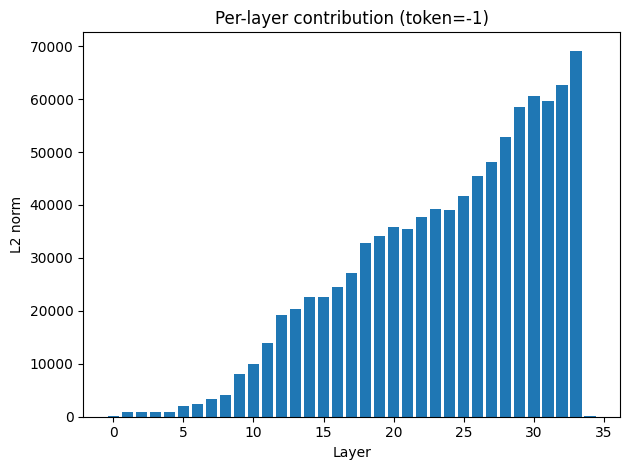

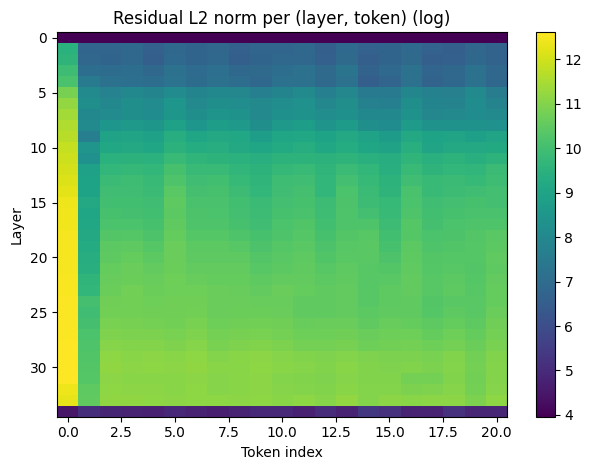

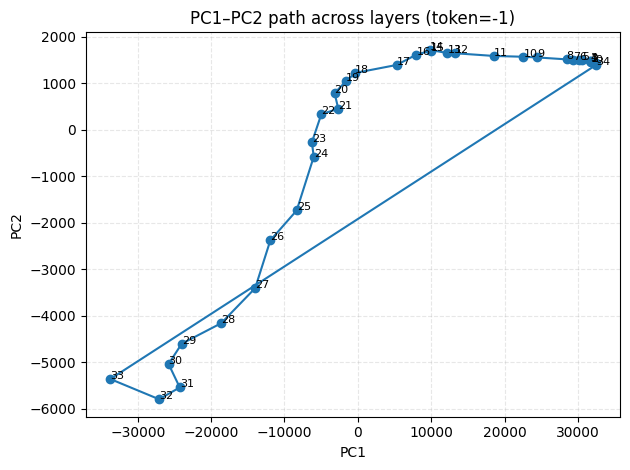

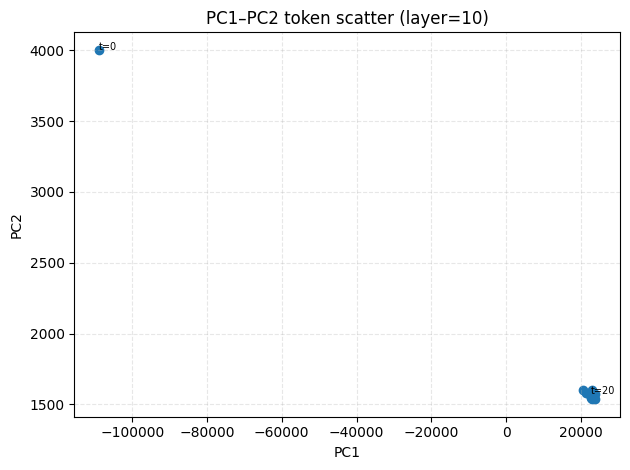

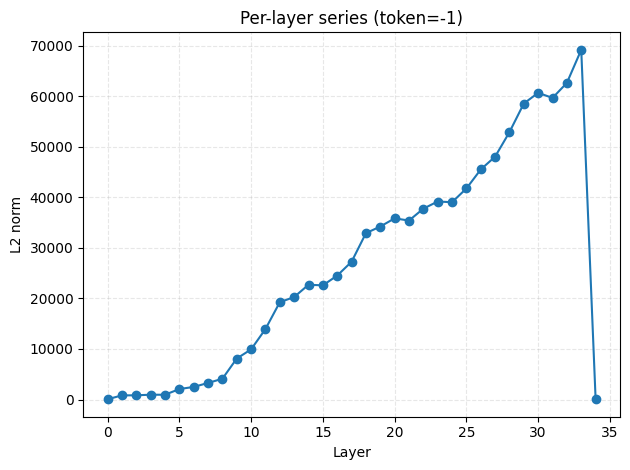

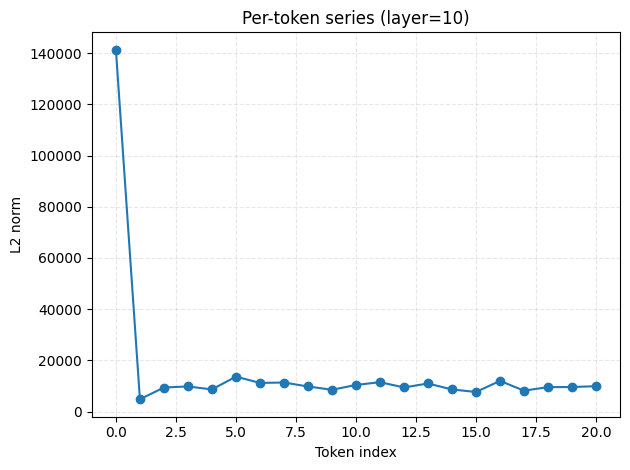

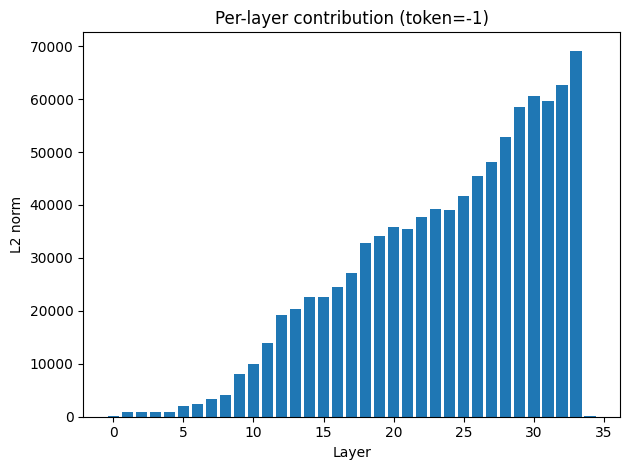

In [41]:
from abstainer.src.residual_viz import *

# 1) Norm heatmap
norm_LT = analyze_residual_stream(all_streams, reduction="norm")
plot_heatmap_LT(norm_LT, title="Residual L2 norm per (layer, token)", log_scale=True)

# 2) Token path in PCA plane
pca_L_T_3 = analyze_residual_stream(all_streams, reduction="pca")
plot_token_path_from_pca(pca_L_T_3, token_index=-1)

# 3) Layer scatter in PCA plane
plot_layer_scatter_from_pca(pca_L_T_3, layer_index=10, token_indices=range(0, pca_L_T_3.shape[1], 2))

# 4) Per-token series across layers
plot_token_series_from_LT(norm_LT, token_index=-1, ylabel="L2 norm")

# 5) Per-layer series across tokens
plot_layer_series_from_LT(norm_LT, layer_index=10, ylabel="L2 norm")

# 6) Per-layer contributions for a token (bar chart)
plot_token_contributions_from_LT(norm_LT, token_index=-1, ylabel="L2 norm")

# # 7) Δ heatmap (compare two prompts)
# norm_A = analyze_residual_stream(residual_stream_A, reduction="norm")
# norm_B = analyze_residual_stream(residual_stream_B, reduction="norm")
# plot_delta_heatmap_LT(norm_A, norm_B, title="Δ L2 norm (B − A)")

# 8) If you started with reduction="none"
# rs_none = analyze_residual_stream(all_streams, reduction="none")
# norm_from_none = summarize_to_norm(rs_none)
# plot_heatmap_LT(norm_from_none, title="Norm (from raw)")


In [7]:
all_rs = get_all_residual_streams(model, tokenizer, "Asdasdasdasdad")
print([x.abs().sum().item() for x in all_rs])  # sum of each layer’s activations


[10624.0, 55808.0, 64000.0, 77824.0, 92160.0, 142336.0, 183296.0, 209920.0, 256000.0, 296960.0, 354304.0, 405504.0, 471040.0, 518144.0, 573440.0, 655360.0, 716800.0, 802816.0, 884736.0, 937984.0, 983040.0, 1122304.0, 1228800.0, 1507328.0, 1794048.0, 1892352.0, 2310144.0, 2605056.0, 2785280.0, 3047424.0, 3244032.0, 3375104.0, 3358720.0, 3588096.0, 22656.0]


In [8]:
all_rs[-1].var(dim=0)

tensor([0.2383, 0.9023, 0.5664,  ..., 0.4570, 1.1641, 5.2188],
       dtype=torch.bfloat16)

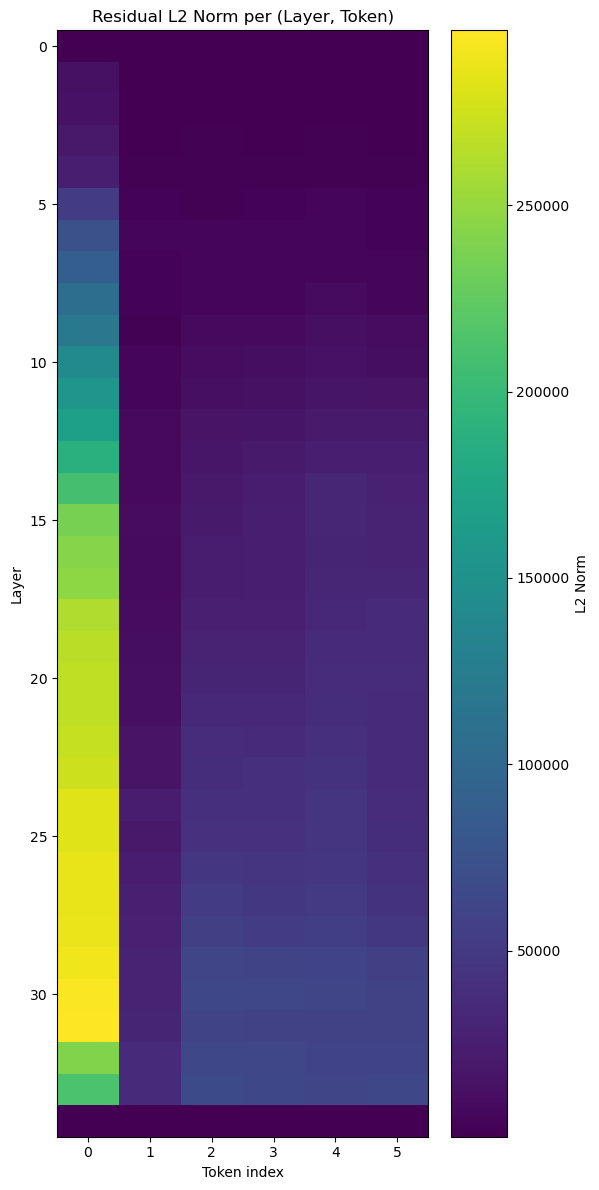

In [9]:
from abstainer.src.probes import analyze_residual_stream, get_all_residual_streams
from abstainer.src.residual_viz import plot_heatmap_LT

# Get residual streams for a simple prompt
prompt = "What is machine learning?"
all_streams = get_all_residual_streams(model, tokenizer, prompt)

# Create a layer-token summary using L2 norm
norm_LT = analyze_residual_stream(all_streams, reduction="norm")

# Plot the heatmap
fig = plot_heatmap_LT(
    norm_LT,
    title="Residual L2 Norm per (Layer, Token)",
    show_colorbar=True,
    colorbar_label="L2 Norm"
)


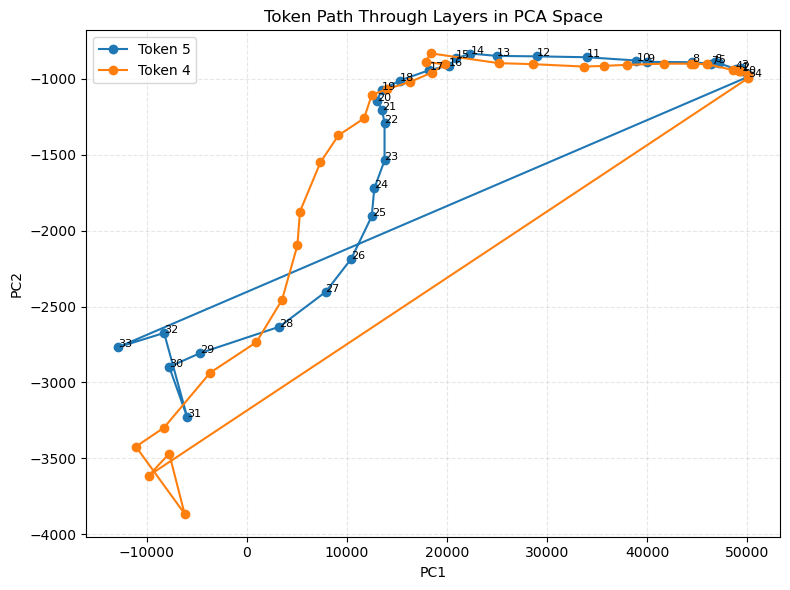

In [10]:
from abstainer.src.residual_viz import plot_token_path_from_pca

# Use the same residual streams from previous example
# Analyze using PCA for visualization (3 components)
pca_L_T_3 = analyze_residual_stream(all_streams, reduction="pca")

# Plot the path of the last token through layers in PCA space
fig = plot_token_path_from_pca(
    pca_L_T_3,
    token_indices=[-1, -2],
    annotate_layers=True,
    title="Token Path Through Layers in PCA Space",
    show_arrows=True,
    arrow_spacing=3
)


/home/sergio/projects/MATS-Project/abstainer/src/residual_viz.py:1348: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=legend_loc)


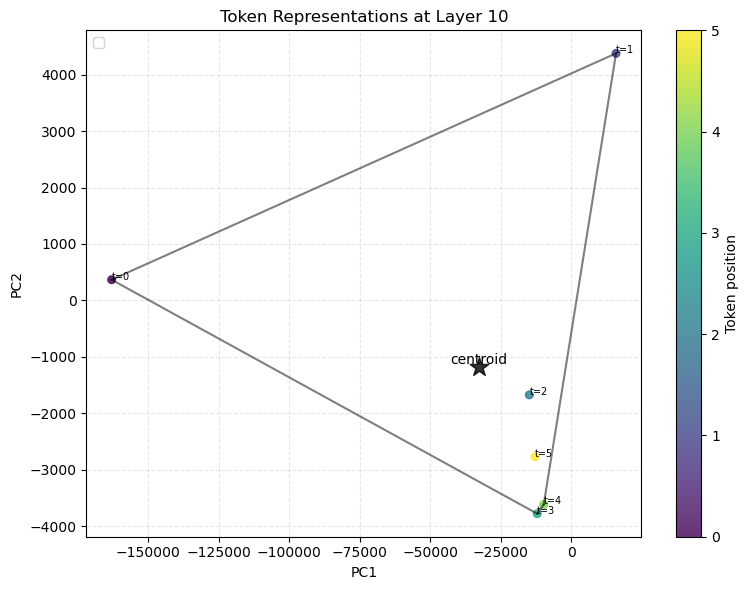

In [11]:
from abstainer.src.residual_viz import plot_layer_scatter_from_pca

# Use the same PCA-reduced data from previous example
# Plot token representations at a specific layer
fig = plot_layer_scatter_from_pca(
    pca_L_T_3,
    layer_index=33,  # Middle layer
    token_indices=slice(None),  # All tokens
    title="Token Representations at Layer 10",
    color_by="index",  # Color by token index
    label_tokens=True,
    add_convex_hull=True,
    add_centroid=True
)


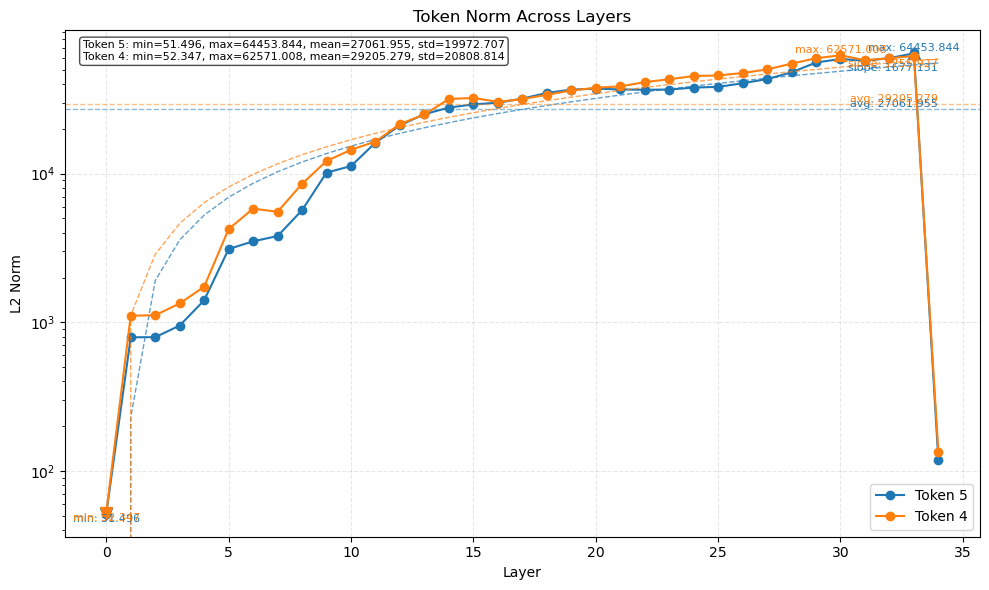

In [12]:
from abstainer.src.residual_viz import plot_token_series_from_LT

# Use the norm_LT data from the first example
# Plot how a token's norm changes across layers
fig = plot_token_series_from_LT(
    norm_LT,
    token_indices=[-1, -2],  # Last two tokens
    title="Token Norm Across Layers",
    ylabel="L2 Norm",
    show_legend=True,
    show_stats=True,
    show_min_max=True,
    show_average=True,
    show_trend=True,
    log_scale=True
)


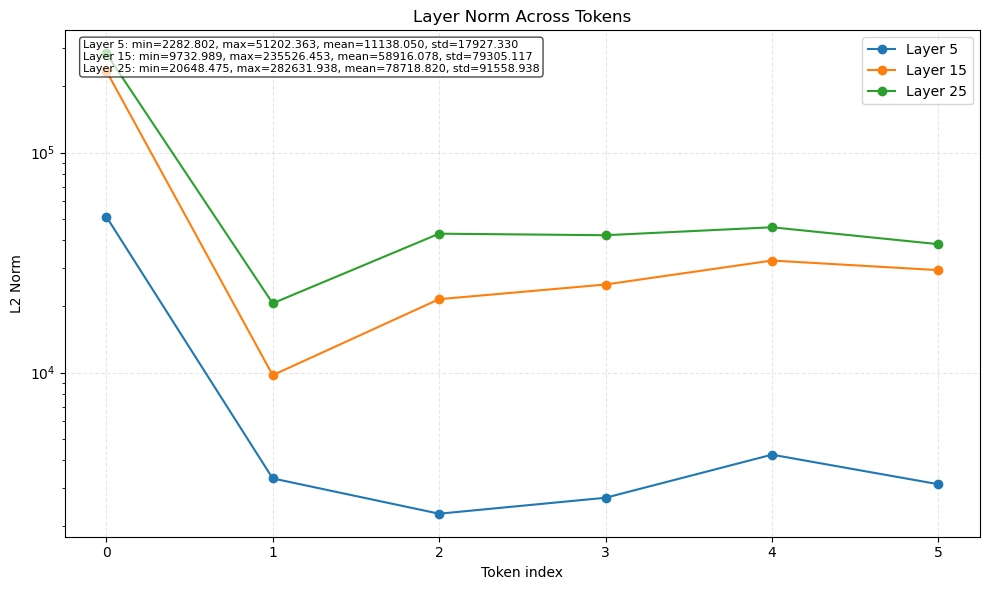

In [13]:
from abstainer.src.residual_viz import plot_layer_series_from_LT

# Use the norm_LT data from the first example
# Plot how a layer's norm changes across tokens
fig = plot_layer_series_from_LT(
    norm_LT,
    layer_indices=[5, 15, 25],  # Early, middle, and late layers
    title="Layer Norm Across Tokens",
    ylabel="L2 Norm",
    show_legend=True,
    show_stats=True,
    log_scale=True,
    highlight_tokens=[-1]  # Highlight the last token
)


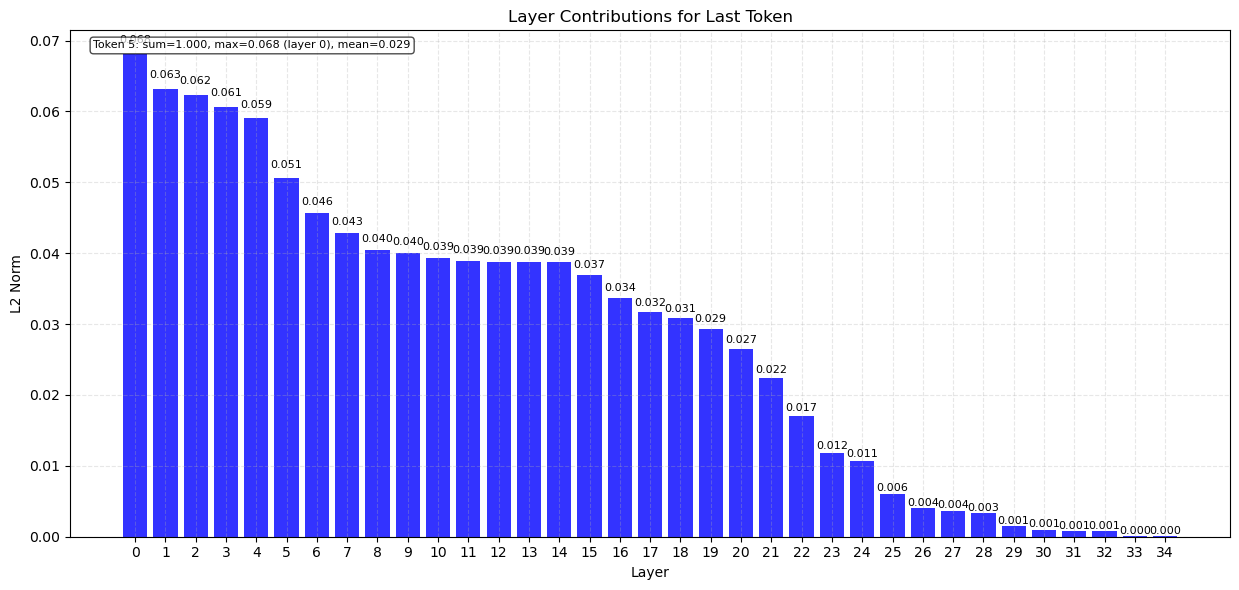

In [14]:
from abstainer.src.residual_viz import plot_token_contributions_from_LT

# Use the norm_LT data from the first example
# Plot layer-wise contributions for a specific token
fig = plot_token_contributions_from_LT(
    norm_LT,
    token_indices=-1,  # Last token
    title="Layer Contributions for Last Token",
    ylabel="L2 Norm",
    show_values=True,
    sort_by_value=True,  # Sort layers by contribution
    normalize=True,  # Show as percentage of total
    show_stats=True,
    highlight_layers=[10, 20, 30]  # Highlight specific layers
)


/home/sergio/anaconda3/envs/abstainer/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:867: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


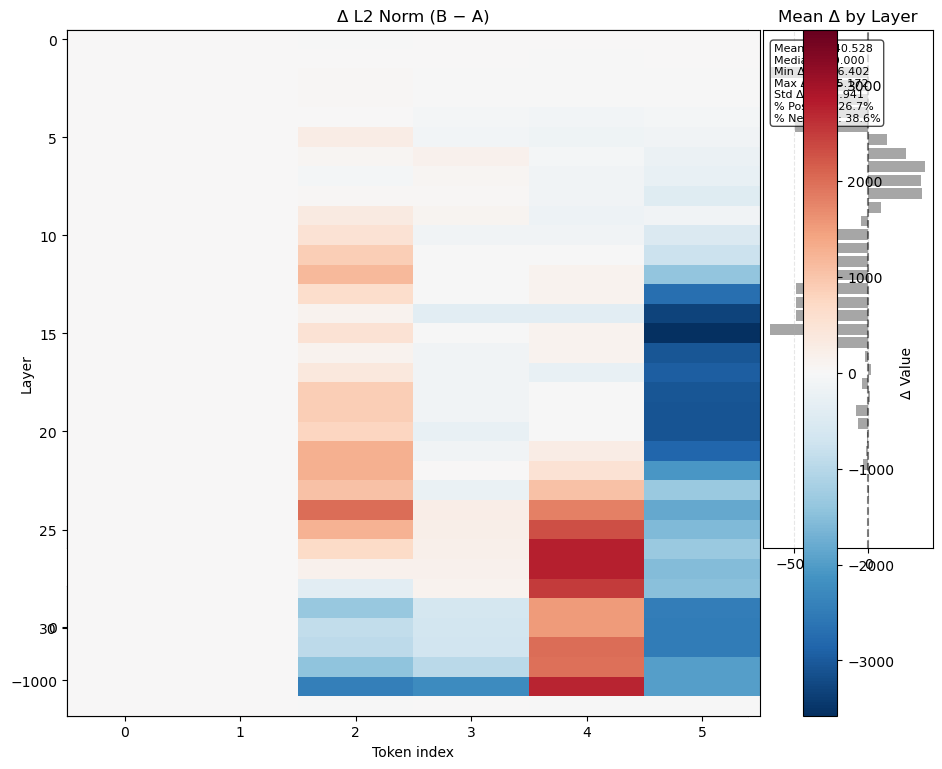

In [16]:
from abstainer.src.probes import analyze_residual_stream, get_all_residual_streams
from abstainer.src.residual_viz import plot_delta_heatmap_LT

# Get residual streams for two different prompts
prompt_a = "What is machine learning?"
prompt_b = "What are machine learning?"

# Get residual streams for both prompts
streams_a = get_all_residual_streams(model, tokenizer, prompt_a)
streams_b = get_all_residual_streams(model, tokenizer, prompt_b)

# Create layer-token summaries using L2 norm
norm_a = analyze_residual_stream(streams_a, reduction="norm")
norm_b = analyze_residual_stream(streams_b, reduction="norm")

# Plot the difference between the two prompts
fig = plot_delta_heatmap_LT(
    norm_a,
    norm_b,
    title="Δ L2 Norm (B − A)",
    condition_a_name="ML Question",
    condition_b_name="DL Question",
    show_colorbar=True,
    center_colormap=True,
    show_side_plots=True,
    show_stats=True
)


In [17]:
from abstainer.src.experiment import run_combined_experiment
from abstainer.src.model import load_model

# Load your model
tokenizer, model = load_model("google/gemma-3-4b-it")

# Run the combined experiment
results = run_combined_experiment(
    model=model,
    tokenizer=tokenizer,
    output_dir="./results/my_experiment",
    subject="Physics",  # Optional filter
    form="V2_letters",  # Use one of the Likert description styles
    custom_labels=["A", "B", "C", "D", "E"],  # Optional custom labels
    verbose=True
)

# The results include statistics and file paths
print(f"Processed {results['likert_stats']['completed_questions']} questions")
print(f"Hidden state shape: {results['hidden_stats']['hidden_state_shape']}")

[autoreload of abstainer.src failed: Traceback (most recent call last):
  File "/home/sergio/anaconda3/envs/abstainer/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 325, in check
    superreload(m, reload, self.old_objects)
    ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sergio/anaconda3/envs/abstainer/lib/python3.13/site-packages/IPython/extensions/autoreload.py", line 580, in superreload
    module = reload(module)
  File "/home/sergio/anaconda3/envs/abstainer/lib/python3.13/importlib/__init__.py", line 129, in reload
    _bootstrap._exec(spec, module)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 1026, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/sergio/projects/MATS-Project/abstainer/src/__init__.py", line 9, in <module>
    from .experiment import run_hidden_states_experiment, load_hidd

Processing 50 questions with Likert form 'V2_letters'


100%|██████████| 50/50 [04:33<00:00,  5.48s/it]


Saved Likert results for 50 questions to results/my_experiment/likert_results_V2_letters.json
Saved hidden states for 50 questions to results/my_experiment/hidden_states_V2_letters.npz
Saved metadata to results/my_experiment/hidden_states_V2_letters.json
Processed 50 questions
Hidden state shape: (35, 2560)
